In [17]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit



# 1. ARIMA
Select p and q within (0, 20) to match lag terms. 


In [3]:
df = pd.read_csv("./data/spy.csv").iloc[:, 1:]
df["date"] = pd.to_datetime(df["date"])
train = df[(df["date"] >= "2015-01-01") & (df["date"] <= "2019-01-07")][
    ["date", "close"]
]
test = df[(df["date"] >= "2019-01-08") & (df["date"] <= "2019-12-31")][
    ["date", "close"]
]

## 1.1 Preprocessing

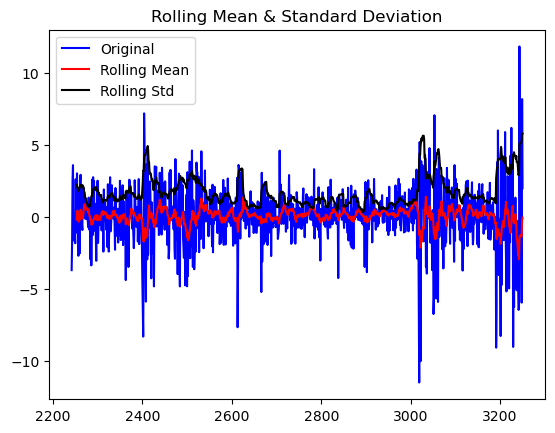

ADF Statistic: -6.779152
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [4]:
# check stationary
def check_stationarity(data):
    # rolling statistics
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()
    # plot rolling statistics
    plt.plot(data, color="blue", label="Original")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()
    # Dickey-Fuller test
    result = adfuller(data)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))


# check
check_stationarity(train["close"].diff(1).dropna())

# stationary after first differenc

## 1.2 Fit model

In [5]:
# stepwise_model = auto_arima(
#     train["close"],
#     start_p=1,
#     start_q=1,
#     max_p=21,
#     max_q=21,
#     # m=12,
#     start_P=0,
#     # seasonal=True,
#     d=1,
#     # D=1,
#     trace=True,
#     error_action="ignore",
#     suppress_warnings=True,
#     # stepwise=True,
#     stepwise=False,
# )
# print(stepwise_model.aic())

# # fit the model
# stepwise_model.fit(train["close"])

In [6]:
# Modified auto_arima call
stepwise_model = auto_arima(
    train["close"],
    start_p=1,
    start_q=1,
    max_p=21,
    max_q=21,
    start_P=0,  #
    d=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
)

print(stepwise_model.aic())

# Fit the model
stepwise_model.fit(train["close"])

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=4294.248, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=4296.086, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=4294.772, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=4296.097, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=4294.599, Time=0.11 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=4296.357, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=4296.104, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=4292.171, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=4291.748, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=4293.486, Time=0.26 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=4296.408, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=4295.054, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=4291.848, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=4290.981, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=4292.643, Time=0.62 sec
 ARIMA(3,1

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

# 2. Linear regression

## 2.1 Only price

In [7]:
X_train, X_test, y_train, y_test = pd.read_pickle("./data/only_price.pkl")

# print(X_train.head())

In [8]:
X_train

,close_lag_1,high_lag_1,low_lag_1,open_lag_1,close_lag_3,high_lag_3,low_lag_3,open_lag_3,close_lag_5,high_lag_5,low_lag_5,open_lag_5,close_lag_8,high_lag_8,low_lag_8,open_lag_8,close_lag_21,high_lag_21,low_lag_21,open_lag_21
date,,,,,,,,,,,,,,,,,,,,
2015-02-03,201.92,202.03,197.86,200.05,201.9902,202.30,198.68,200.38,202.7400,204.1200,201.74,202.97,206.10,206.2600,202.33,203.99,205.43,206.88,204.1800,206.38
2015-02-04,204.84,204.85,202.55,203.00,199.4500,202.17,199.13,200.57,200.1400,204.2900,199.91,204.17,204.97,206.1000,204.81,205.79,201.72,204.37,201.3500,204.17
2015-02-05,204.06,205.38,203.51,203.92,201.9200,202.03,197.86,200.05,201.9902,202.3000,198.68,200.38,205.45,205.5600,203.85,204.71,199.82,202.72,198.8550,202.09
2015-02-06,206.12,206.30,204.77,204.86,204.8400,204.85,202.55,203.00,199.4500,202.1700,199.13,200.57,202.74,204.1200,201.74,202.97,202.31,202.72,200.8800,201.42
2015-02-09,205.55,207.24,204.92,206.56,204.0600,205.38,203.51,203.92,201.9200,202.0300,197.86,200.05,200.14,204.2900,199.91,204.17,205.90,206.16,203.9900,204.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,247.75,251.40,246.45,249.58,246.1800,246.18,233.76,235.97,240.7000,249.7100,239.98,246.74,255.08,257.9500,253.28,257.20,274.58,274.58,268.3272,269.60
2019-01-02,249.92,250.19,247.47,249.56,248.0700,248.29,238.96,242.57,234.3400,240.8355,234.27,239.04,251.26,259.4000,249.35,255.17,273.98,275.55,272.4300,273.71
2019-01-03,250.18,251.21,245.95,245.98,247.7500,251.40,246.45,249.58,246.1800,246.1800,233.76,235.97,247.17,251.6200,244.65,249.86,275.65,276.28,273.4500,273.81


In [9]:
y_train

date
2015-02-03    204.84
2015-02-04    204.06
2015-02-05    206.12
2015-02-06    205.55
2015-02-09    204.63
               ...  
2018-12-31    249.92
2019-01-02    250.18
2019-01-03    244.21
2019-01-04    252.39
2019-01-07    254.38
Name: close, Length: 989, dtype: float64

In [10]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model with the training data
lr_model.fit(X_train, y_train)

# Coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Predict on the training data
y_train_pred = lr_model.predict(X_train)

# Calculate metrics on training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Predict on the testing data
y_test_pred = lr_model.predict(X_test)

# Calculate metrics on testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

{
    "coefficients": coefficients,
    "intercept": intercept,
    "training_metrics": {"MSE": train_mse, "R2": train_r2},
    "testing_metrics": {"MSE": test_mse, "R2": test_r2},
}

{'coefficients': array([ 1.17795635, -0.37178363, -0.14500632,  0.29137233, -0.08002397,
         0.1829232 ,  0.18340663, -0.32422458,  0.05217717,  0.0204808 ,
        -0.05406838,  0.07893058, -0.12007117,  0.10597592, -0.03332761,
         0.02421723,  0.15872072, -0.12607095, -0.05531355,  0.03176575]),
 'intercept': 0.5992459100430665,
 'training_metrics': {'MSE': 3.9201684025813344, 'R2': 0.9954548509785227},
 'testing_metrics': {'MSE': 4.637023606118479, 'R2': 0.9772206650270339}}

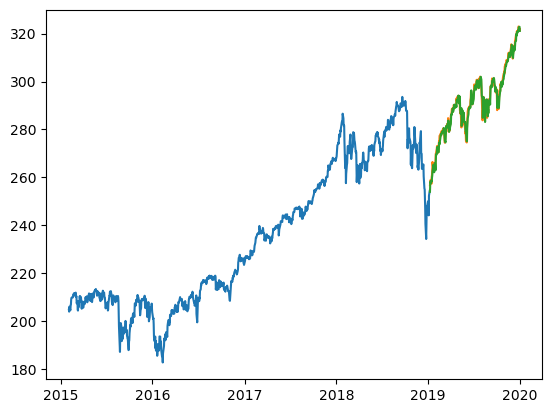

In [11]:
plt.plot(y_train.index, y_train)
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_test_pred)

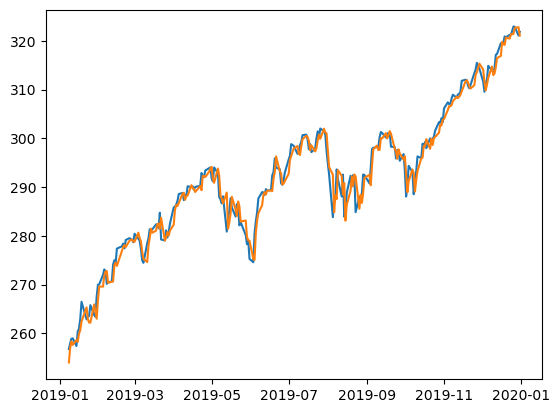

In [12]:
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_test_pred)

In [13]:
import statsmodels.api as sm

# Assuming X_train, X_test, y_train, y_test are defined and loaded correctly in the environment

# Adding a constant term for intercept
X_train_sm = sm.add_constant(X_train)

# Fit the OLS model
ols_model = sm.OLS(y_train, X_train_sm).fit()

# Summary of the model
model_summary = ols_model.summary()

# Adding a constant to X_test for predictions
X_test_sm = sm.add_constant(X_test)

# Making predictions on the test set
y_test_pred_ols = ols_model.predict(X_test_sm)

# Calculating metrics for the test set
test_mse_ols = mean_squared_error(y_test, y_test_pred_ols)
test_r2_ols = r2_score(y_test, y_test_pred_ols)

model_summary, test_mse_ols, test_r2_ols

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  close   R-squared:                       0.995
 Model:                            OLS   Adj. R-squared:                  0.995
 Method:                 Least Squares   F-statistic:                 1.060e+04
 Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
 Time:                        21:11:57   Log-Likelihood:                -2078.9
 No. Observations:                 989   AIC:                             4200.
 Df Residuals:                     968   BIC:                             4303.
 Df Model:                          20                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

In [33]:
y_test_pred_df = pd.DataFrame(y_test_pred, index=y_test.index, columns=['pred'])
y_test_pred_df['actual'] = y_test
sum((y_test_pred_df.diff(1)['pred'] * y_test_pred_df.diff(1)['actual']) < 0)

117

In [34]:
y_test_pred_df.shape

(248, 2)

## 2.2 Price + Technical Indicators

In [14]:
X_train_ti, X_test_ti, y_train_ti, y_test_ti = pd.read_pickle("./data/price_ti.pkl")

In [15]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model with the training data
lr_model.fit(X_train_ti, y_train_ti)

# Coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Predict on the training data
y_train_pred = lr_model.predict(X_train_ti)

# Calculate metrics on training data
train_mse = mean_squared_error(y_train_ti, y_train_pred)
train_r2 = r2_score(y_train_ti, y_train_pred)

# Predict on the testing data
y_test_pred = lr_model.predict(X_test_ti)

# Calculate metrics on testing data
test_mse = mean_squared_error(y_test_ti, y_test_pred)
test_r2 = r2_score(y_test_ti, y_test_pred)

{
    # "coefficients": coefficients,
    # "intercept": intercept,
    "training_metrics": {"MSE": train_mse, "R2": train_r2},
    "testing_metrics": {"MSE": test_mse, "R2": test_r2},
}

{'training_metrics': {'MSE': 2.766045478661261, 'R2': 0.996792972237514},
 'testing_metrics': {'MSE': 6.797227617249328, 'R2': 0.9666086830835808}}

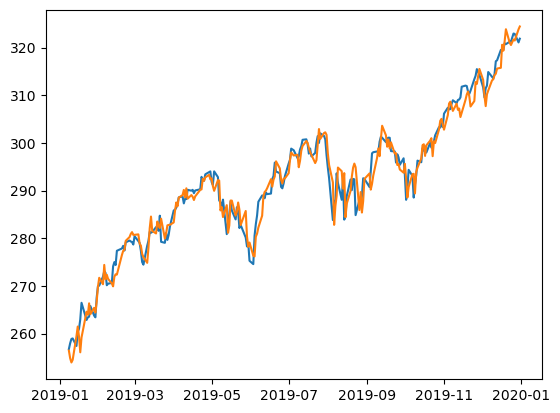

In [16]:
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, y_test_pred)

# Random Forest

In [24]:
# Function 1: Train and Fit a Random Forest Model
def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    """
    Trains and fits a Random Forest model.
    
    Parameters:
    - X_train: Training features
    - y_train: Training target variable
    - n_estimators: The number of trees in the forest
    - max_depth: The maximum depth of the tree
    
    Returns:
    - A trained Random Forest model
    """
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function 2: Run Grid Search with Cross Validation
def run_grid_search(model, param_grid, X_train, y_train, n_splits=5):
    """
    Performs grid search with cross validation.
    
    Parameters:
    - model: The model for which the grid search is performed
    - param_grid: Dictionary with parameters names as keys and lists of parameter settings to try as values
    - X_train: Training features
    - y_train: Training target variable
    - n_splits: Number of splits for Time Series Split
    
    Returns:
    - The GridSearchCV instance after fitting
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gscv = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1)
    gscv.fit(X_train, y_train)
    return gscv

# Function 3: Test MSE and R2
def test_mse_r2(model, X_test, y_test):
    """
    Calculates and prints the MSE and R^2 for the test set.
    
    Parameters:
    - model: The trained model to evaluate
    - X_test: Testing features
    - y_test: Testing target variable
    """
    predictions = model.predict(X_test)
    plt.plot(y_test.index, y_test)
    plt.plot(y_test.index, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"MSE: {mse}, R^2: {r2}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -0.7097142899994616
MSE: 108.53815188764496, R^2: 0.4668073468651275


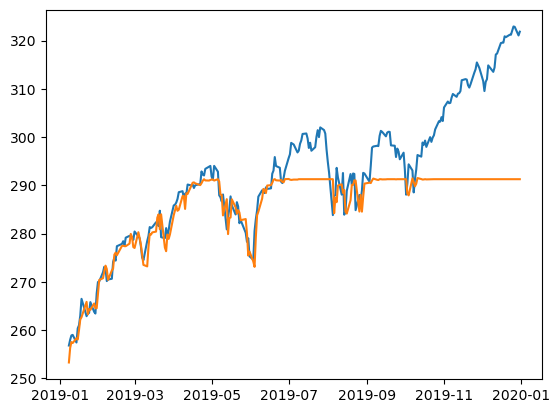

In [25]:
model = train_random_forest(X_train, y_train, n_estimators=100, max_depth=None)

# Perform Grid Search with Time Series Cross-Validation
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_model = run_grid_search(model, param_grid, X_train, y_train, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model.best_params_}")
print(f"Best Score: {best_model.best_score_}")

# Test MSE and R2 with the best model found
test_mse_r2(best_model, X_test, y_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: -0.7783066634258625
MSE: 117.7796086218704, R^2: 0.42140877733675053


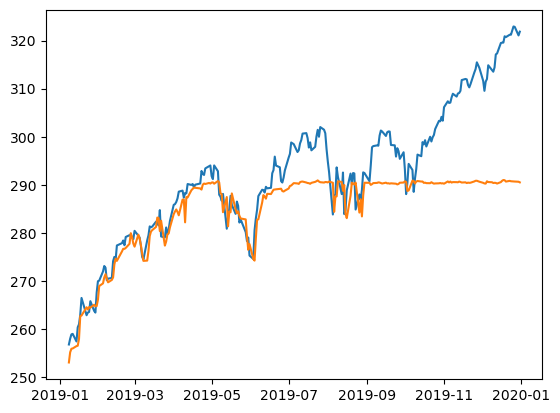

In [26]:
model_ti = train_random_forest(X_train_ti, y_train_ti, n_estimators=100, max_depth=None)

best_model_ti = run_grid_search(model, param_grid, X_train_ti, y_train_ti, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_ti.best_params_}")
print(f"Best Score: {best_model_ti.best_score_}")

# Test MSE and R2 with the best model found
test_mse_r2(best_model_ti, X_test_ti, y_test_ti)

### *Limitation of Random Forest*: ***Extrapolation***